In [10]:
%load_ext autoreload
%autoreload

import numpy as np
import pandas as pd
import pickle

from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold, GroupKFold
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
import seaborn as sns

from equationmodel_ann import ann_mlp_regression, prediction_rmse_error, ann_linear_compare_graph
from util import ADD_data_loader, combineDF, filteringDF, getFreeSpacePathLoss, makeXforGraphWithGroupingFrequency,\
                makeXforGraph, inverseScale, samplingData, normalizeData,train_2d_graph, train_3d_graph

desired_width=1220
pd.set_option('display.width', desired_width)
pd.set_option('display.max_columns',120)
pd.options.display.float_format = "{:.2f}".format

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


ADD data preprocessing
../data/PLdata_iksan_wt_400.csv: distance filtering(before):(109210, 4)
../data/PLdata_iksan_wt_400.csv: distance filtering(after):(10396, 4)
../data/PLdata_iksan_wt_2249.csv: distance filtering(before):(108873, 4)
../data/PLdata_iksan_wt_2249.csv: distance filtering(after):(10396, 4)
../data/PLdata_iksan_wt_1399.csv: distance filtering(before):(109060, 4)
../data/PLdata_iksan_wt_1399.csv: distance filtering(after):(10396, 4)
          type  distance  pathloss  heightTM  frequency  heightTB  heightB  heightM
type 6367    m   2.97165   111.218    0.0219        400        30       15        2
     6368    m   2.96216   115.428    0.0219        400        30       15        2
     6369    m   2.95751   111.618    0.0219        400        30       15        2
     6370    m   2.95313   108.948    0.0220        400        30       15        2
     6371    m   2.94392   103.928    0.0220        400        30       15        2
Combined data set: (31188, 8)
type filterin

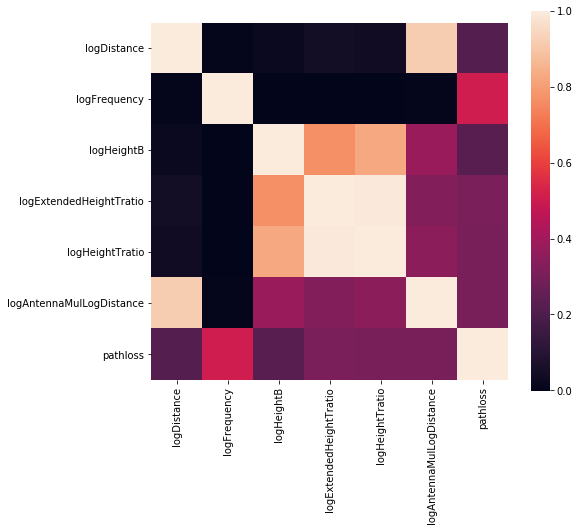

In [5]:
%autoreload

iksan_fileList = {'../data/PLdata_iksan_wt_400.csv':[('frequency', 400), ('heightTB',30), ('heightB',15), ('heightM',2)],
            '../data/PLdata_iksan_wt_1399.csv':[('frequency', 1399), ('heightTB',30), ('heightB',15), ('heightM',2)],
            '../data/PLdata_iksan_wt_2249.csv':[('frequency', 2249), ('heightTB',30), ('heightB',15), ('heightM',2)]}
nonsan_fileList = {'../data/PLdata_nonsan_wt_400.csv':[('frequency', 400), ('heightTB',30), ('heightB',15), ('heightM',2)],
            '../data/PLdata_nonsan_wt_1399.csv':[('frequency', 1399), ('heightTB',30), ('heightB',15), ('heightM',2)],
            '../data/PLdata_nonsan_wt_2249.csv':[('frequency', 2249), ('heightTB',30), ('heightB',15), ('heightM',2)]}
paju_fileList = {'../data/PLdata_paju_wt_400.csv':[('frequency', 400), ('heightTB',100), ('heightB',7), ('heightM',2)],
            '../data/PLdata_paju_wt_1399.csv':[('frequency', 1399), ('heightTB',100), ('heightB',7), ('heightM',2)],
            '../data/PLdata_paju_wt_2249.csv':[('frequency', 2249), ('heightTB',100), ('heightB',7), ('heightM',2)]}

addIksan = ADD_data_loader(iksan_fileList)
print("Iksan data:",addIksan.shape)
print("")
addNonsan = ADD_data_loader(nonsan_fileList)
print("Nonsan data:",addNonsan.shape)
print("")
addPaju = ADD_data_loader(paju_fileList)
print("Paju data:",addPaju.shape)
print("")

# print(addIksan.describe())
# print(addNonsan.describe())
# print(addPaju.describe())

addData = combineDF([addIksan, addNonsan, addPaju])
print("antenna_b height filtering-before(data count):",addData.shape)
addData = filteringDF(addData, 'heightTM', [10,100])
print("antenna_b height filtering-after(data count):",addData.shape)

print("freespace pathloss filtering-before(data count):",addData.shape)
addData['freePathloss'] = getFreeSpacePathLoss(addData['distance'],addData['frequency'])
addData = addData[addData['pathloss'] >= addData['freePathloss']]
print("freespace pathloss filtering-after(data count):",addData.shape)

# print("ADD data sample:\n",addData.head())

targetCols = ['logDistance', 'logFrequency', 'logHeightB', 'logHeightM','logExtendedHeightTratio', 'logHeightTratio', 'logAntennaMulLogDistance', 'pathloss']
xCols = ['logDistance', 'logFrequency', 'logHeightB', 'logHeightM','logExtendedHeightTratio', 'logHeightTratio', 'logAntennaMulLogDistance']
yCols = 'pathloss'

print("\nADD data description")
print(addData.describe()['pathloss'])
# print(addData[['logDistance', 'logFrequency', 'logHeightB', 'logHeightM', 'logHeightTratio', 'logAntennaMulLogDistance', 'pathloss']].describe())
print("\nCovariance Matrix - ADD data[pathloss]")
print(addData.cov()['pathloss'])
print("\nCovariance Matrix - ADD data[Target Columns]")
print("Target Columns:", targetCols)
print(addData[['logDistance', 'logFrequency', 'logHeightB', 'logExtendedHeightTratio', 'logHeightTratio', 'logAntennaMulLogDistance', 'pathloss']].cov()['pathloss'])

print("\nCorrelation Matrix - ADD data[Target Columns]")
print("Target Columns:", targetCols)
corrMat = addData[['logDistance', 'logFrequency', 'logHeightB', 'logExtendedHeightTratio', 'logHeightTratio', 'logAntennaMulLogDistance', 'pathloss']].corr()
print(corrMat)
f, ax = plt.subplots(figsize=(8,7))
sns.heatmap(corrMat, square=True)


In [6]:
%autoreload
samplingRatio = 0.7
addDataSample = samplingData(addData[targetCols], samplingRatio)
# addDataSample.sort_values(by=['logDistance'])

normalizer = 'standard'

X, scaler = normalizeData(addDataSample[xCols], scaler = normalizer)
Y = np.array(addDataSample[yCols])

data distribution(before)
       logDistance  logFrequency   logHeightB   logHeightM  logExtendedHeightTratio  logHeightTratio  logAntennaMulLogDistance     pathloss
count  79125.00000   79125.00000  79125.00000  79125.00000              79125.00000      79125.00000               79125.00000  79125.00000
mean       0.30807       3.03282      1.05325      0.30103                 -0.40215         -0.32041                   0.32494    127.46660
std        0.11901       0.31582      0.15991      0.00000                  0.25838          0.32522                   0.13568     16.61257
min        0.00003       2.60206      0.84510      0.30103                 -0.95020         -1.00000                   0.00004     85.05800
25%        0.23252       2.60206      0.84510      0.30103                 -0.61776         -0.62342                   0.23656    114.90700
50%        0.32884       3.14582      1.17609      0.30103                 -0.38604         -0.27300                   0.33415    127.

In [11]:
from sklearn.decomposition import PCA
pca = PCA()

print(pca.fit(X))
print(pca.explained_variance_ratio_)
print(pca.singular_values_)

PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)
[4.99133639e-01 2.86121192e-01 1.66639764e-01 4.63813132e-02
 1.71363929e-03 1.04523571e-05 1.54242596e-34]
[4.07278878e+02 3.08360314e+02 2.35327558e+02 1.24152362e+02
 2.38639963e+01 1.86376258e+00 7.15954842e-15]
